In [47]:
import sahi

from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from sahi.utils.cv import read_image_as_pil

from matplotlib import pyplot as plt
import cv2
import pandas as pd
from ultralytics import YOLO

from typing import List, Dict

In [2]:
from sahi.utils.yolov8 import (
    download_yolov8m_model,
)

from sahi import AutoDetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from IPython.display import Image

In [86]:
def intersection_over_union(gt, pred):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(gt[0], pred[0])
    yA = max(gt[1], pred[1])
    xB = min(gt[2], pred[2])
    yB = min(gt[3], pred[3])
    # if there is no overlap between predicted and ground-truth box
    if xB < xA or yB < yA:
        return 0.0
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1)
    boxBArea = (pred[2] - pred[0] + 1) * (pred[3] - pred[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [3]:
# download YOLOV8m model to 'models/yolov5s6.pt'
yolov8_model_path = "models/yolov8m.pt"
download_yolov8m_model(yolov8_model_path)

In [15]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=yolov8_model_path,
    confidence_threshold=0.4,
    device="cuda:1", # or 'cuda:0'
)

In [413]:
predictions = get_prediction(read_image("people_frames/people_frames_1.jpg"), detection_model)

In [414]:
#results in form tlwh
results = predictions.to_coco_annotations()

In [328]:
image = cv2.imread("people_frames/people_frames_1.jpg")
height, width = image.shape[:2]

In [379]:
predicted_boxes = pd.DataFrame(columns=['image', 'confidence', 'iou', 'TP', 'FP', 'Precision', 'Recall'], index=range(len(results)))

In [359]:
with open("datasets/labels/people_frames_1.txt", "r") as f:
    boxes= f.readlines()

#gt boxes are in the format x_c, y_c, width, height
gt_boxes = [box.split(" ")[1:] for box in boxes]

In [360]:
gt_boxes = [list(map(lambda x: float(x.strip()), box)) for box in gt_boxes]

In [361]:
def xywh_tlbr(box):
    #get box (x_c, y_c, width, height) -> (tlbr)
    box[0]=box[0]-box[2]/2
    box[1]=box[1]-box[3]/2
    box[2]=box[0]+box[2]
    box[3]=box[1]+box[3]
    return box

In [362]:
def tlwh_tlbr(box):
    #get box (top left, width, height) -> (tlbr)
    box[2]=box[0]+box[2]
    box[3]=box[1]+box[3]
    return box

In [363]:
def scale_box(width, height, box):
    box[0]*=width
    box[2]*=width
    box[1]*=height
    box[3]*=height
    return box

In [364]:
#change xywh to tlbr format
gt_boxes = [xywh_tlbr(box) for box in gt_boxes]

In [365]:
#multiply by the image height and width
gt_boxes=[scale_box(width, height, box) for box in gt_boxes]

In [366]:
gt_boxes

[[204.75936, 245.82987, 235.51967999999997, 308.83005],
 [225.68976, 256.93983000000003, 257.43984, 322.91973],
 [397.26000000000005, 36.82988999999999, 423.82992, 104.53995],
 [495.82992, 51.40017, 522.39984, 119.96991000000001],
 [695.54016, 25.689959999999996, 709.2604799999999, 95.96987999999999],
 [791.53968, 6.829919999999996, 808.69008, 64.25999999999999],
 [845.54016, 77.11010999999999, 876.40032, 144.82988999999998],
 [897.79968, 70.26021, 925.2595199999998, 137.97027],
 [284.11008, 101.10987, 309.8304, 161.10980999999998],
 [169.26000000000002, 247.69017, 201.82992000000002, 323.97003],
 [860.99952, 37.690110000000004, 890.96976, 98.54001000000001],
 [836.5996799999999, 3.4303499999999985, 862.9996799999999, 70.57017],
 [656.5704000000001, 1.2900600000000013, 671.5704000000001, 56.29014],
 [360.86016, 4.860269999999997, 383.71008, 55.57005],
 [638.00016, 21.999870000000005, 654.43056, 62.70993],
 [811.57008, 4.859999999999997, 826.57008, 65.57003999999999],
 [448.459680000000

In [415]:
for i, result in enumerate(results):
    ious=[]
    if result['category_id']==0: #only person
        predicted_boxes.loc[i]['image'] = 'people_frames_1.jpg'
        predicted_boxes.loc[i]['confidence']=result['score']
        pr_box=result['bbox']
        print(pr_box)
        pr_box=tlwh_tlbr(pr_box)
        for gt_box in gt_boxes:
            iou = intersection_over_union(gt_box, pr_box)
            ious.append(iou)
        if max(ious)>0.5:
                predicted_boxes.loc[i]['iou']=max(ious)
                predicted_boxes.loc[i]['TP']=1
                predicted_boxes.loc[i]['FP']=0
        else:
            predicted_boxes.loc[i]['iou']=max(ious)
            predicted_boxes.loc[i]['FP']=1
            predicted_boxes.loc[i]['TP']=0



[16.67926597595215, 398.27117919921875, 53.877885818481445, 95.8289794921875]
[570.5089111328125, 475.6861267089844, 51.35882568359375, 63.924102783203125]
[332.95965576171875, 324.4489440917969, 39.686920166015625, 102.13516235351562]
[704.6060180664062, 351.05218505859375, 56.78759765625, 93.41473388671875]
[375.3856201171875, 225.7949981689453, 36.3695068359375, 86.95146179199219]
[722.7588500976562, 159.4525604248047, 34.98114013671875, 83.27687072753906]
[569.6017456054688, 254.01109313964844, 35.28570556640625, 75.27516174316406]
[129.9181365966797, 219.3926239013672, 36.16429138183594, 86.09791564941406]
[731.86328125, 236.70680236816406, 39.07177734375, 86.08506774902344]
[463.63916015625, 87.23003387451172, 29.656494140625, 66.51136016845703]
[100.24942779541016, 22.068626403808594, 34.29175567626953, 59.70037841796875]
[284.02313232421875, 135.6312255859375, 29.931243896484375, 71.1922607421875]
[352.93994140625, 119.75743103027344, 31.150909423828125, 74.89187622070312]
[46.

In [416]:
results

[{'image_id': None,
  'bbox': [16.67926597595215,
   398.27117919921875,
   70.5571517944336,
   494.10015869140625],
  'score': 0.8637837171554565,
  'category_id': 0,
  'category_name': 'person',
  'segmentation': [],
  'iscrowd': 0,
  'area': 5163},
 {'image_id': None,
  'bbox': [570.5089111328125,
   475.6861267089844,
   621.8677368164062,
   539.6102294921875],
  'score': 0.8500073552131653,
  'category_id': 0,
  'category_name': 'person',
  'segmentation': [],
  'iscrowd': 0,
  'area': 3283},
 {'image_id': None,
  'bbox': [332.95965576171875,
   324.4489440917969,
   372.6465759277344,
   426.5841064453125],
  'score': 0.8332661390304565,
  'category_id': 0,
  'category_name': 'person',
  'segmentation': [],
  'iscrowd': 0,
  'area': 4053},
 {'image_id': None,
  'bbox': [704.6060180664062,
   351.05218505859375,
   761.3936157226562,
   444.4669189453125],
  'score': 0.8299207091331482,
  'category_id': 0,
  'category_name': 'person',
  'segmentation': [],
  'iscrowd': 0,
  'are

In [417]:
predicted_boxes

,image,confidence,iou,TP,FP,Precision,Recall
0,people_frames_1.jpg,0.863784,0.964226,1,0,NaN,NaN
1,people_frames_1.jpg,0.850007,0.968488,1,0,NaN,NaN
2,people_frames_1.jpg,0.833266,0.960686,1,0,NaN,NaN
3,people_frames_1.jpg,0.829921,0.971055,1,0,NaN,NaN
4,people_frames_1.jpg,0.741605,0.978326,1,0,NaN,NaN
5,people_frames_1.jpg,0.741118,0.95813,1,0,NaN,NaN
6,people_frames_1.jpg,0.697009,0.969261,1,0,NaN,NaN
7,people_frames_1.jpg,0.694631,0.985419,1,0,NaN,NaN
8,people_frames_1.jpg,0.643226,0.978013,1,0,NaN,NaN
9,people_frames_1.jpg,0.613121,0.956479,1,0,NaN,NaN


In [418]:
num_gt = len(gt_boxes)

In [419]:
num_gt

39

In [420]:
predicted_boxes.sort_values(by='confidence', ascending=False)
predicted_boxes

,image,confidence,iou,TP,FP,Precision,Recall
0,people_frames_1.jpg,0.863784,0.964226,1,0,NaN,NaN
1,people_frames_1.jpg,0.850007,0.968488,1,0,NaN,NaN
2,people_frames_1.jpg,0.833266,0.960686,1,0,NaN,NaN
3,people_frames_1.jpg,0.829921,0.971055,1,0,NaN,NaN
4,people_frames_1.jpg,0.741605,0.978326,1,0,NaN,NaN
5,people_frames_1.jpg,0.741118,0.95813,1,0,NaN,NaN
6,people_frames_1.jpg,0.697009,0.969261,1,0,NaN,NaN
7,people_frames_1.jpg,0.694631,0.985419,1,0,NaN,NaN
8,people_frames_1.jpg,0.643226,0.978013,1,0,NaN,NaN
9,people_frames_1.jpg,0.613121,0.956479,1,0,NaN,NaN


In [432]:
#compute precision and recall
for i, row in predicted_boxes.iterrows():
    predicted_boxes.loc[i]['Precision']=predicted_boxes[:i+1]['TP'].sum()/len(predicted_boxes[:i+1])
    predicted_boxes.loc[i]['Recall']=predicted_boxes[:i+1]['TP'].sum()/num_gt

In [433]:
predicted_boxes

,image,confidence,iou,TP,FP,Precision,Recall
0,people_frames_1.jpg,0.863784,0.964226,1,0,1.0,0.025641
1,people_frames_1.jpg,0.850007,0.968488,1,0,1.0,0.051282
2,people_frames_1.jpg,0.833266,0.960686,1,0,1.0,0.076923
3,people_frames_1.jpg,0.829921,0.971055,1,0,1.0,0.102564
4,people_frames_1.jpg,0.741605,0.978326,1,0,1.0,0.128205
5,people_frames_1.jpg,0.741118,0.95813,1,0,1.0,0.153846
6,people_frames_1.jpg,0.697009,0.969261,1,0,1.0,0.179487
7,people_frames_1.jpg,0.694631,0.985419,1,0,1.0,0.205128
8,people_frames_1.jpg,0.643226,0.978013,1,0,1.0,0.230769
9,people_frames_1.jpg,0.613121,0.956479,1,0,1.0,0.25641


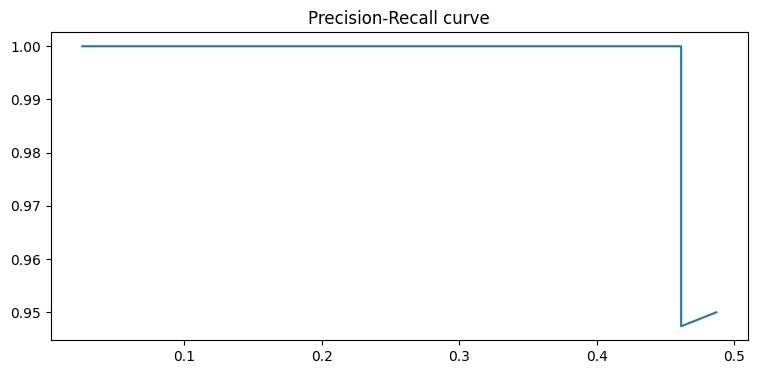

In [436]:
plt.figure(figsize=(9, 4))
plt.plot(predicted_boxes['Recall'], predicted_boxes['Precision'])
plt.title("Precision-Recall curve")
plt.show()

In [437]:
image = cv2.imread("people_frames/people_frames_1.jpg")

In [438]:
for result in results:
    print(result)

{'image_id': None, 'bbox': [16.67926597595215, 398.27117919921875, 70.5571517944336, 494.10015869140625], 'score': 0.8637837171554565, 'category_id': 0, 'category_name': 'person', 'segmentation': [], 'iscrowd': 0, 'area': 5163}
{'image_id': None, 'bbox': [570.5089111328125, 475.6861267089844, 621.8677368164062, 539.6102294921875], 'score': 0.8500073552131653, 'category_id': 0, 'category_name': 'person', 'segmentation': [], 'iscrowd': 0, 'area': 3283}
{'image_id': None, 'bbox': [332.95965576171875, 324.4489440917969, 372.6465759277344, 426.5841064453125], 'score': 0.8332661390304565, 'category_id': 0, 'category_name': 'person', 'segmentation': [], 'iscrowd': 0, 'area': 4053}
{'image_id': None, 'bbox': [704.6060180664062, 351.05218505859375, 761.3936157226562, 444.4669189453125], 'score': 0.8299207091331482, 'category_id': 0, 'category_name': 'person', 'segmentation': [], 'iscrowd': 0, 'area': 5304}
{'image_id': None, 'bbox': [375.3856201171875, 225.7949981689453, 411.755126953125, 312.7

[16.67926597595215, 398.27117919921875, 70.5571517944336, 494.10015869140625]
[16.67926597595215, 398.27117919921875, 87.23641777038574, 892.371337890625]
[570.5089111328125, 475.6861267089844, 621.8677368164062, 539.6102294921875]
[570.5089111328125, 475.6861267089844, 1192.3766479492188, 1015.2963562011719]
[332.95965576171875, 324.4489440917969, 372.6465759277344, 426.5841064453125]
[332.95965576171875, 324.4489440917969, 705.6062316894531, 751.0330505371094]
[704.6060180664062, 351.05218505859375, 761.3936157226562, 444.4669189453125]
[704.6060180664062, 351.05218505859375, 1465.9996337890625, 795.5191040039062]
[375.3856201171875, 225.7949981689453, 411.755126953125, 312.7464599609375]
[375.3856201171875, 225.7949981689453, 787.1407470703125, 538.5414581298828]
[722.7588500976562, 159.4525604248047, 757.739990234375, 242.72943115234375]
[722.7588500976562, 159.4525604248047, 1480.4988403320312, 402.18199157714844]
[569.6017456054688, 254.01109313964844, 604.887451171875, 329.28625

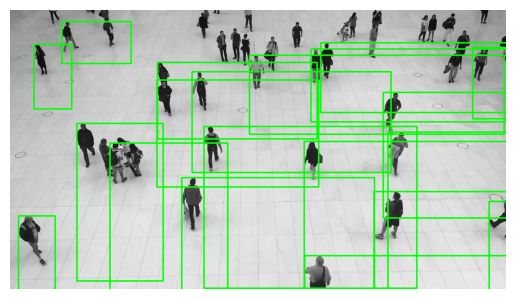

In [439]:
for result in results:
    pr_box=result['bbox']
    print(pr_box)
    pr_box=tlwh_tlbr(pr_box)
    print(pr_box)
    cv2.rectangle(image, (int(pr_box[0]), int(pr_box[1])), (int(pr_box[2]), int(pr_box[3])), color=(0, 255, 0), thickness=2)
plt.imshow(image)
plt.axis('off')
plt.show()

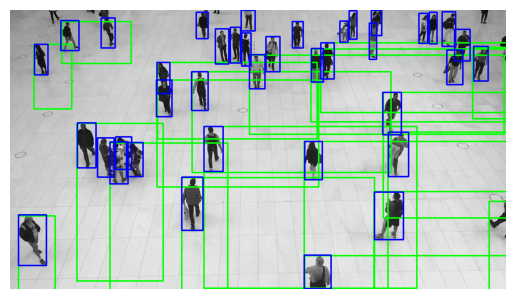

In [440]:
for box in gt_boxes:
    cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(0, 0, 255), thickness=2)
plt.imshow(image)
plt.axis('off')
plt.show()

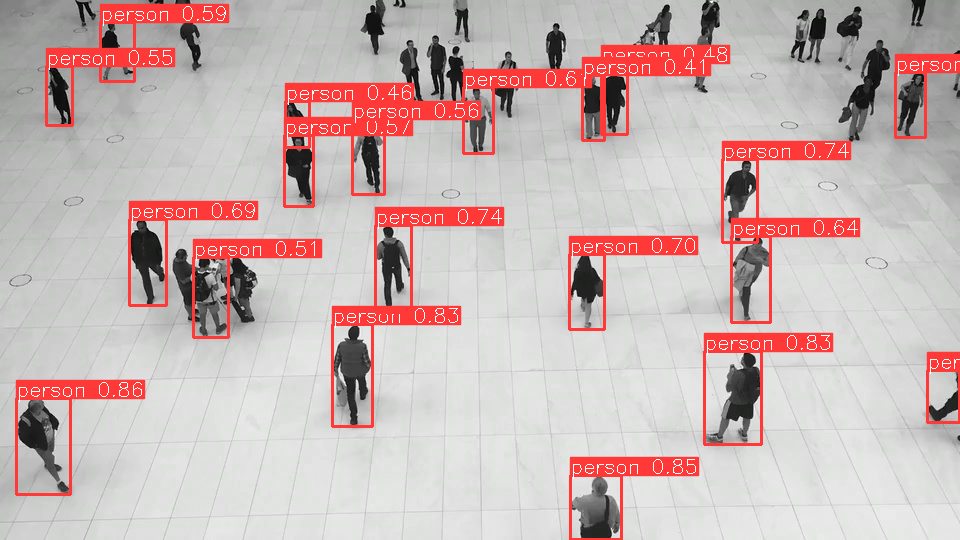

In [24]:
result.export_visuals(export_dir="demo_data/")
Image("demo_data/prediction_visual.png")

In [18]:
image = cv2.imread("demo_data/prediction_visual.png")
cv2.imshow("image", image)

error: OpenCV(4.8.0) /io/opencv/modules/highgui/src/window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [36]:
result = get_sliced_prediction(
    "people_frames/people_frames_1.jpg",
    detection_model,
    slice_height = 512,
    slice_width = 512,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2
)

Performing prediction on 6 number of slices.


In [37]:
results = result.to_coco_annotations()

In [38]:
results

[{'image_id': None,
  'bbox': [703.8653259277344,
   351.0527648925781,
   57.71270751953125,
   94.18447875976562],
  'score': 0.92024165391922,
  'category_id': 0,
  'category_name': 'person',
  'segmentation': [],
  'iscrowd': 0,
  'area': 5435},
 {'image_id': None,
  'bbox': [16.207965850830078,
   397.8651428222656,
   54.34977340698242,
   96.57192993164062],
  'score': 0.9120569229125977,
  'category_id': 0,
  'category_name': 'person',
  'segmentation': [],
  'iscrowd': 0,
  'area': 5248},
 {'image_id': None,
  'bbox': [570.3317108154297,
   475.2215270996094,
   52.53782653808594,
   64.55892944335938],
  'score': 0.8761662244796753,
  'category_id': 0,
  'category_name': 'person',
  'segmentation': [],
  'iscrowd': 0,
  'area': 3391},
 {'image_id': None,
  'bbox': [722.7589111328125,
   159.45281982421875,
   35.174163818359375,
   83.73202514648438],
  'score': 0.8745273351669312,
  'category_id': 0,
  'category_name': 'person',
  'segmentation': [],
  'iscrowd': 0,
  'area'

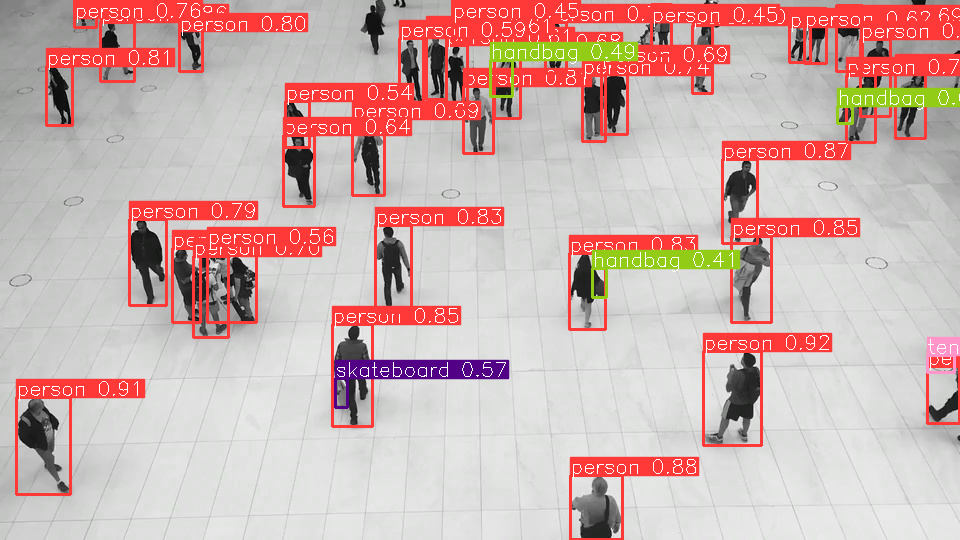

In [39]:
result.export_visuals(export_dir="demo_data/")
Image("demo_data/prediction_visual.png")

In [5]:
source_image_dir = "people_frames/"

In [6]:
predict(
    model_type='yolov8',
    model_path=yolov8_model_path,
    model_device="cuda:1",
    model_confidence_threshold=0.4,
    source=source_image_dir,
    slice_height=256,
    slice_width=256,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
)

There are 341 listed files in folder: people_frames/


Performing inference on images:   0%|          | 0/341 [00:00<?, ?it/s]

Performing prediction on 15 number of slices.


Performing inference on images:   0%|          | 1/341 [00:13<1:19:04, 13.95s/it]

Prediction time is: 13884.63 ms
Performing prediction on 15 number of slices.


Performing inference on images:   1%|          | 2/341 [00:24<1:07:10, 11.89s/it]

Prediction time is: 10390.54 ms
Performing prediction on 15 number of slices.


Performing inference on images:   1%|          | 3/341 [00:34<1:03:02, 11.19s/it]

Prediction time is: 10310.32 ms
Performing prediction on 15 number of slices.


Performing inference on images:   1%|          | 4/341 [00:45<1:01:23, 10.93s/it]

Prediction time is: 10482.02 ms
Performing prediction on 15 number of slices.


Performing inference on images:   1%|▏         | 5/341 [00:57<1:04:03, 11.44s/it]

Prediction time is: 12294.30 ms
Performing prediction on 15 number of slices.


Performing inference on images:   2%|▏         | 6/341 [01:08<1:02:57, 11.28s/it]

Prediction time is: 10911.33 ms
Performing prediction on 15 number of slices.


Performing inference on images:   2%|▏         | 7/341 [01:18<1:01:07, 10.98s/it]

Prediction time is: 10336.28 ms
Performing prediction on 15 number of slices.


Performing inference on images:   2%|▏         | 8/341 [01:29<59:56, 10.80s/it]  

Prediction time is: 10363.30 ms
Performing prediction on 15 number of slices.


Performing inference on images:   3%|▎         | 9/341 [01:39<59:16, 10.71s/it]

Prediction time is: 10471.58 ms
Performing prediction on 15 number of slices.


Performing inference on images:   3%|▎         | 10/341 [01:52<1:01:46, 11.20s/it]

Prediction time is: 12230.70 ms
Performing prediction on 15 number of slices.


Performing inference on images:   3%|▎         | 11/341 [02:02<1:00:48, 11.06s/it]

Prediction time is: 10687.02 ms
Performing prediction on 15 number of slices.


Performing inference on images:   4%|▎         | 12/341 [02:13<59:35, 10.87s/it]  

Prediction time is: 10400.76 ms
Performing prediction on 15 number of slices.


Performing inference on images:   4%|▍         | 13/341 [02:24<59:02, 10.80s/it]

Prediction time is: 10600.12 ms
Performing prediction on 15 number of slices.


Performing inference on images:   4%|▍         | 14/341 [02:34<58:27, 10.73s/it]

Prediction time is: 10486.48 ms
Performing prediction on 15 number of slices.


Performing inference on images:   4%|▍         | 15/341 [02:47<1:01:06, 11.25s/it]

Prediction time is: 12373.14 ms
Performing prediction on 15 number of slices.


Performing inference on images:   5%|▍         | 16/341 [02:57<1:00:04, 11.09s/it]

Prediction time is: 10662.22 ms
Performing prediction on 15 number of slices.


Performing inference on images:   5%|▍         | 17/341 [03:08<58:49, 10.89s/it]  

Prediction time is: 10388.82 ms
Performing prediction on 15 number of slices.


Performing inference on images:   5%|▌         | 18/341 [03:18<58:09, 10.80s/it]

Prediction time is: 10558.46 ms
Performing prediction on 15 number of slices.


Performing inference on images:   5%|▌         | 18/341 [03:24<1:01:13, 11.37s/it]


KeyboardInterrupt: 